In [1]:
#load necessary packages for data analysis
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import math
import statistics
from scipy.stats import iqr
from scipy.stats import chi2_contingency

In [2]:
#load necessary packages for machine learning
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [3]:
#Load data
df = pd.read_csv("D:/technicalprepare/Project/marketing.csv")

#Preview data
df.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,y
0,0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,no
1,1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,no
3,3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,no
4,4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,no


In [4]:
#Explore information of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   45211 non-null  int64 
 1   age          45211 non-null  int64 
 2   job          44923 non-null  object
 3   marital      45211 non-null  object
 4   education    43354 non-null  object
 5   default      45211 non-null  object
 6   balance      45211 non-null  int64 
 7   housing      45211 non-null  object
 8   loan         45211 non-null  object
 9   contact      32191 non-null  object
 10  day_of_week  45211 non-null  int64 
 11  month        45211 non-null  object
 12  duration     45211 non-null  int64 
 13  campaign     45211 non-null  int64 
 14  pdays        45211 non-null  int64 
 15  previous     45211 non-null  int64 
 16  y            45211 non-null  object
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [5]:
#Explore missing value 
#Create a list of tuples containing column name and missing rate
missing_rates = [(column, len(df[df[column].isnull()]) / len(df) * 100) for column in df.columns]

#Sort the list of tuples by missing rates in ascending order
sorted_missing_rates = sorted(missing_rates, key=lambda df: df[1])

#Print the sorted missing rates
for column, missing_rate in sorted_missing_rates:
    print(f'{column} missing rate: {missing_rate:.2f}%')

Unnamed: 0 missing rate: 0.00%
age missing rate: 0.00%
marital missing rate: 0.00%
default missing rate: 0.00%
balance missing rate: 0.00%
housing missing rate: 0.00%
loan missing rate: 0.00%
day_of_week missing rate: 0.00%
month missing rate: 0.00%
duration missing rate: 0.00%
campaign missing rate: 0.00%
pdays missing rate: 0.00%
previous missing rate: 0.00%
y missing rate: 0.00%
job missing rate: 0.64%
education missing rate: 4.11%
contact missing rate: 28.80%


<AxesSubplot:>

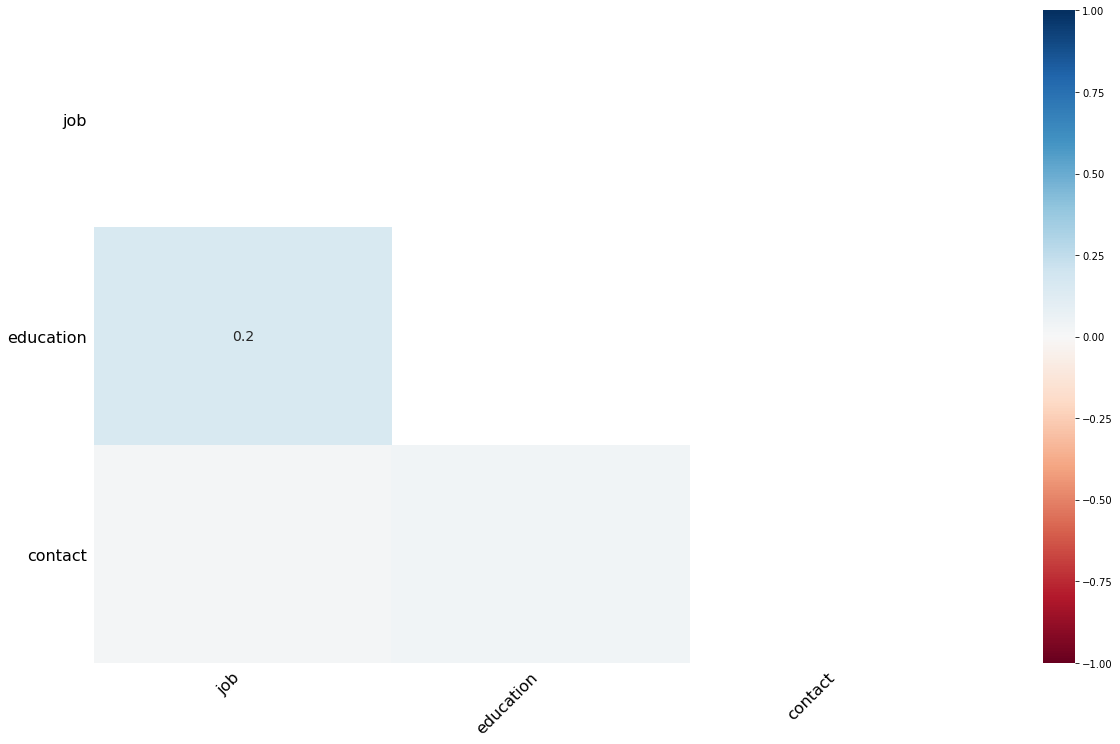

In [6]:
#Explore mechanism of missing 
msno.heatmap(df)

#There is moderate correlation between missing value; therefore, the missing might not completely at random.

In [7]:
#Clean data by dropping unnecessary columns
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop('Unnamed: 0', axis=1)

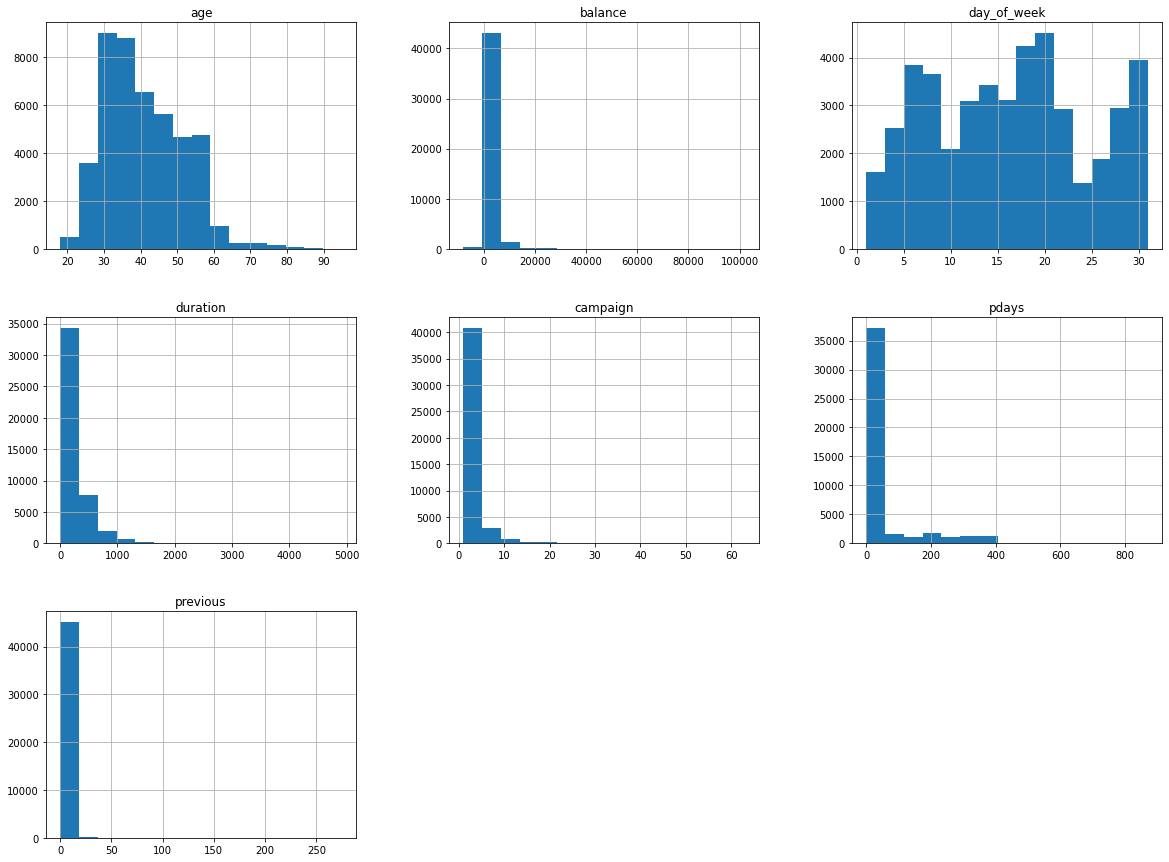

In [8]:
#Explore the distribution of numeric columns
#Get numeric columns
numeric_columns = df_cleaned.select_dtypes(include=['number']).columns

#Change it to list
numeric_columns = numeric_columns.tolist()

# Plot histogram of selected column
df_cleaned[numeric_columns].hist(bins= 15, figsize=(20,15))
plt.rc('axes', labelsize=20)
plt.show()

#Data do not follow a normal distribution; RobustScaler can be a good choice to transform this data.

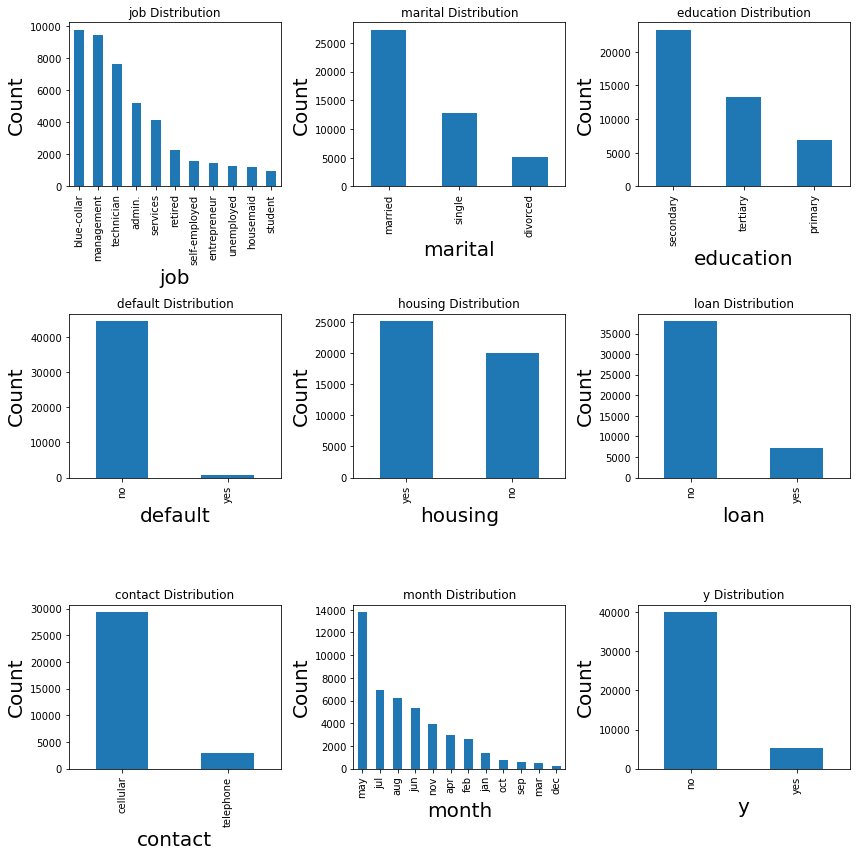

In [9]:
# Explore non-numeric columns
non_numeric_columns = df_cleaned.select_dtypes(exclude=['number']).columns
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Loop through non-numeric columns and plot them in the subplots
for i, column in enumerate(df_cleaned[non_numeric_columns].columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    df_cleaned[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'{column} Distribution')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
# Hide any empty subplots
for i in range(len(df_cleaned[non_numeric_columns].columns), 3*3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

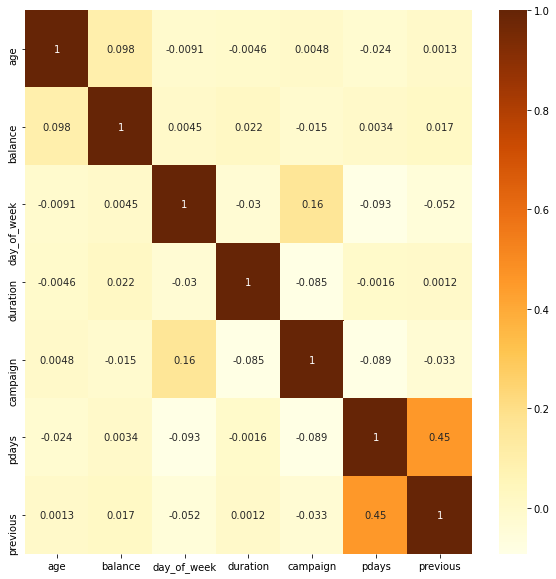

In [10]:
#Explore relationship between numeric features
# Creating the correlation matrix of the numeric features
df_corr_matrix = df[numeric_columns].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
# Create the heatmap using the `heatmap` function of Seaborn
sns.heatmap(df_corr_matrix,cmap="YlOrBr", annot=True)

# Display the heatmap using the `show` method of the `pyplot` module from matplotlib.
plt.show()
#There are very weak correlation between varaibles; therefore they are less likely to cause multicollinearity 

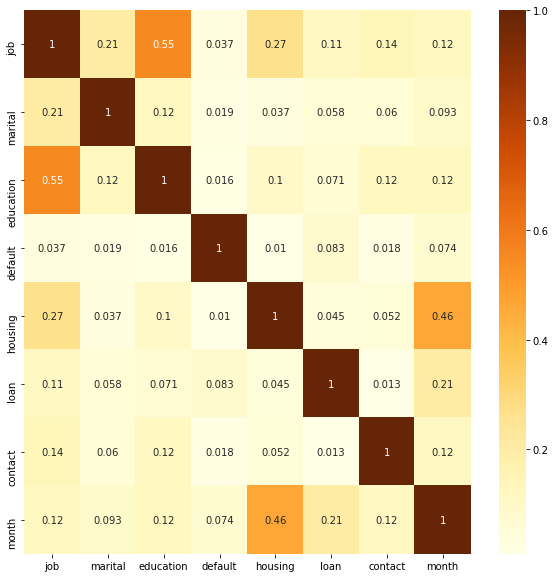

In [11]:
#Explore relationship between non-numeric features
#Get list of non_numeric features
non_numeric_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month']
#Code from https://saturncloud.io/blog/using-pandas-to-calculate-cramers-coefficient-matrix/
#Create the contingency table matrix
def contingency_table_matrix(df):
    columns = df.columns
    matrix = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = stats.chi2_contingency(contingency_table)
            min_categories = min(contingency_table.shape[0], contingency_table.shape[1])
            n = contingency_table.sum().sum()
            V = np.sqrt(chi2 / (n * (min_categories - 1)))
            matrix[i, j] = V
    return pd.DataFrame(matrix, columns=columns, index=columns)

#Generate the Cramer's V coefficient matrix
cramers_v_matrix = contingency_table_matrix(df[non_numeric_columns].dropna())
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cramers_v_matrix,cmap="YlOrBr", annot=True)

plt.show()
#There are strong correlations between certain features:
# 1. Job and Education
# 2. Housing and Month

#These strong correlations might cause multicollinearity.
#This can impact the stability and interpretability of our machine learning model. 
#I plan to mainly develop models that are less sensitive to multicollinearity like tree base.

In [12]:
#Compare statistic for each numeric columns
#I use median, IQR and Mann whitney U because data does not follow normal distribution
numeric_df = pd.concat([df_cleaned[numeric_columns],df['y']],axis=1)
success_num = numeric_df[numeric_df['y'] == 'no']
fail_num = numeric_df[numeric_df['y'] == 'yes']
#Define a function to calculate both median and IQR for a given column
def calculate_median_and_iqr(data):
    median = statistics.median(data.dropna())
    iqr_value = iqr(data.dropna())
    return median, iqr_value

#Define a function to calculate Mann-Whitney U statistics
def calculate_mann_whitney_u(success, fail):
    mann_whitney_u = {}
    for column in numeric_columns:
        u_statistic, p_value = stats.mannwhitneyu(success_num[column], fail_num[column])
        mann_whitney_u[column] = {'U-Statistic': u_statistic, 'p-Value': p_value}
    return mann_whitney_u

#Calculate median and IQR for 'success' and 'fail' sets
success_median_iqr = success_num[numeric_columns].apply(calculate_median_and_iqr)
fail_median_iqr = fail_num[numeric_columns].apply(calculate_median_and_iqr)

#Calculate Mann-Whitney U statistics
mann_whitney_u = calculate_mann_whitney_u(success_num, fail_num)

#Combine the results into a single dataFrame
results_num = pd.DataFrame({
    'Success Median': success_median_iqr.apply(lambda x: x[0]),
    'Success IQR': success_median_iqr.apply(lambda x: x[1]),
    'Fail Median': fail_median_iqr.apply(lambda x: x[0]),
    'Fail IQR': fail_median_iqr.apply(lambda x: x[1]),
    'Mann-Whitney U': [mann_whitney_u[column]['U-Statistic'] for column in numeric_columns],
    'p-Value': [mann_whitney_u[column]['p-Value'] for column in numeric_columns]
}, index=numeric_columns)

results_num
#There are statistically significant differences between the 'success' and 'fail' groups in all features.

,Success Median,Success IQR,Fail Median,Fail IQR,Mann-Whitney U,p-Value
age,39.0,15.0,38.0,19.0,103915109.5,3.140896e-02
balance,417.0,1287.0,733.0,1949.0,86557474.5,3.296923e-101
day_of_week,16.0,13.0,15.0,14.0,99974112.0,1.663039e-10
duration,164.0,184.0,426.0,481.0,40625701.0,0.000000e+00
campaign,2.0,2.0,2.0,2.0,90300543.5,9.742452e-72
pdays,-1.0,0.0,-1.0,99.0,85889711.5,1.242059e-235
previous,0.0,0.0,0.0,1.0,83972625.0,1.745912e-283


In [13]:
#Compare statistic for non-categorical values
non_numeric_df = pd.concat([df_cleaned[non_numeric_columns],df['y']],axis=1)
success_non = non_numeric_df[non_numeric_df['y'] == 'no']
fail_non = non_numeric_df[non_numeric_df['y'] == 'yes']
#Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Column', 'Category', 'Success %', 'Fail %', 'Chi-Square', 'p-Value'])
#Iterate through each non_numeric_columns
for column in non_numeric_columns:
    #Calculate the percentage of each category for the 'success' dataFrame
    success_percentage = (success_non[column].value_counts(normalize=True) * 100).reset_index()
    success_percentage.columns = ['Category', 'Success %']

    #Calculate the percentage of each category for the 'fail' dataFrame
    fail_percentage = (fail_non[column].value_counts(normalize=True) * 100).reset_index()
    fail_percentage.columns = ['Category', 'Fail %']

    #Merge 'success' and 'fail' percentages on category
    merged_percentage = pd.merge(success_percentage, fail_percentage, on='Category', how='outer')

    #Create a contingency table for the current column
    contingency_table = pd.crosstab(merged_percentage['Category'], columns=[merged_percentage['Success %'], merged_percentage['Fail %']], margins=True)

    #Perform the Chi-square test for the current column
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    #Add Chi-square statistic and p-value to the merged_percentage 
    merged_percentage['Chi-Square'] = chi2
    merged_percentage['p-Value'] = p
    #Add the name of the current column to the merged_percentage
    merged_percentage['Column'] = column
    #Append the results for the current column to the main results 
    results_df = pd.concat([results_df, merged_percentage], ignore_index=True)
results_df
# There is no statistically significant result for non-numeric variables.
# Traditional statistics have limitations in capturing relationships compared to machine learning.
# This analysis is primarily intended for exploratory data analysis.

,Column,Category,Success %,Fail %,Chi-Square,p-Value
0,job,blue-collar,22.748815,13.472883,110.0,0.753814
1,job,management,20.563174,24.757374,110.0,0.753814
2,job,technician,17.033881,15.984776,110.0,0.753814
3,job,admin.,11.444993,12.007612,110.0,0.753814
4,job,services,9.541696,7.021884,110.0,0.753814
5,job,retired,4.406575,9.819220,110.0,0.753814
6,job,self-employed,3.509126,3.558516,110.0,0.753814
7,job,entrepreneur,3.438540,2.340628,110.0,0.753814
8,job,housemaid,2.851165,2.074215,110.0,0.753814
9,job,unemployed,2.775537,3.843958,110.0,0.753814


In [14]:
#Define X and y for develop mechine learning model
X = df_cleaned[numeric_columns+non_numeric_columns]
y = df_cleaned['y']
#Split data to train and test ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Create a preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('num_features', RobustScaler(), numeric_columns),
    ('cat_features', OneHotEncoder(), non_numeric_columns)
])

#Create the imputer
imputer = SimpleImputer(strategy='most_frequent')
#Create the pipeline including the imputer
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('imputer', imputer)
])
#Preprocess to use in pipeline
pipe = pipeline.fit(X) 
X_train_preprocessed = pipe.transform(X_train)

In [15]:
#Function to fine the best parameter for each model
#Adapte from https://github.com/davidsbatista/machine-learning-notebooks/blob/master/hyperparameter-across-models.ipynb 
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#Define cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=5, shuffle=True, random_state=42, **grid_kwargs):
        skf = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
        for key in self.keys:
            print('Running GridSearchCV for %s.' % key)
            model = self.models[key]
            params = self.params[key]
            full_pipeline = GridSearchCV(model, params, cv=skf, **grid_kwargs)
            full_pipeline.fit(X, y)
            self.grid_searches[key] = full_pipeline
        print('Done.')

    def score_summary(self, sort_by='mean_test_score'):
        frames = []
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_)
            frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = len(frame) * [name]
            frames.append(frame)
        df = pd.concat(frames)
        df = df.sort_values(sort_by, ascending=False)
        df = df.reset_index(drop=True)
        columns_to_drop = ['rank_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
        df = df.drop(columns_to_drop, axis=1)
        columns = df.columns.tolist()
        columns.remove('estimator')
        columns = ['estimator'] + columns
        df = df[columns]
        return df

In [16]:
#Define models to use 
models1 = { 
    'LogisticRegression':LogisticRegression(solver='liblinear'),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC':SVC()
}
#Define parameters to optimise 
params1 = { 
    'LogisticRegression':{'C': [ 1.0, 0.1, 0.01]},
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': [
        { 'n_estimators': [16, 32] },
        {'criterion': ['gini', 'entropy'], 'n_estimators': [8, 16]}],
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC':{ 'C': [0.1, 1, 10]}
}

In [17]:
#Find the best parameters
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train_preprocessed,y_train, cv=5, shuffle=True, random_state=42, scoring='roc_auc', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for LogisticRegression.
Running GridSearchCV for ExtraTreesClassifier.
Running GridSearchCV for RandomForestClassifier.
Running GridSearchCV for AdaBoostClassifier.
Running GridSearchCV for GradientBoostingClassifier.
Running GridSearchCV for SVC.
Done.


,estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,GradientBoostingClassifier,"{'learning_rate': 0.8, 'n_estimators': 32}",0.921829,0.916103,0.921980,0.921357,0.922637,0.920781,0.002375
1,RandomForestClassifier,{'n_estimators': 32},0.919369,0.912861,0.916236,0.917037,0.918739,0.916848,0.002291
2,GradientBoostingClassifier,"{'learning_rate': 0.8, 'n_estimators': 16}",0.912272,0.912019,0.919927,0.914243,0.920811,0.915855,0.003776
3,GradientBoostingClassifier,"{'learning_rate': 1.0, 'n_estimators': 32}",0.884182,0.908618,0.920165,0.914833,0.917528,0.909065,0.013019
4,RandomForestClassifier,"{'criterion': 'entropy', 'n_estimators': 16}",0.907347,0.906634,0.906875,0.904477,0.910345,0.907136,0.001883
5,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 16}",0.904766,0.899660,0.907695,0.910109,0.902525,0.904951,0.003689
6,RandomForestClassifier,{'n_estimators': 16},0.905372,0.895916,0.904586,0.905453,0.908839,0.904033,0.004315
7,GradientBoostingClassifier,"{'learning_rate': 1.0, 'n_estimators': 16}",0.878116,0.908071,0.917152,0.907118,0.909233,0.903938,0.013391
8,AdaBoostClassifier,{'n_estimators': 32},0.906073,0.895555,0.902056,0.900030,0.903508,0.901444,0.003542
9,LogisticRegression,{'C': 0.1},0.899774,0.884851,0.894377,0.891101,0.901510,0.894323,0.006024


In [18]:
#Choose the GradientBoostingClassifier due to its superior ROC score for model development.
#Split data to train and test ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Ceate preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])
#Ceate preprocessing for non_numeric columns
non_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Combine the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', non_numeric_transformer, non_numeric_columns)])

#Define the model
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', GradientBoostingClassifier(learning_rate=0.8, n_estimators=32))])

# Train the model
model1.fit(X_train, y_train)

# Make predictions on the test data
y_test_pred = model1.predict(X_test)

# Calculate ROC AUC score
y_probs = model1.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc = roc_auc_score(y_test, y_probs)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, pos_label='yes')
precision = precision_score(y_test, y_test_pred, pos_label='yes')

print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)
print("Precision Score", precision)
# The F1 score and Precision scores are relatively low compared to ROC and accuracy,
# The model does not classify the positive class well

ROC AUC Score: 0.9140582495891942
Accuracy Score: 0.9025765785690589
F1 Score: 0.5291288081239979
Precision Score 0.6346153846153846


In [19]:
#Define the model
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', GradientBoostingClassifier(learning_rate=0.8, n_estimators=32))])

# Apply SMOTE to balance the class distribution on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(model2.named_steps['preprocessor'].fit_transform(X_train), y_train)

# Retrain the model on the resampled data
model2.named_steps['classifier'].fit(X_train_resampled, y_train_resampled)

# Transform the test data using the same preprocessing steps
X_test_transformed = model2.named_steps['preprocessor'].transform(X_test)

# Make predictions on the test data
y_test_pred = model2.named_steps['classifier'].predict(X_test_transformed)

# Calculate ROC AUC score
y_probs = model2.named_steps['classifier'].predict_proba(X_test_transformed)[:, 1]  # Probability of class 1
roc_auc = roc_auc_score(y_test, y_probs)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, pos_label='yes')
precision = precision_score(y_test, y_test_pred, pos_label='yes')

print("ROC AUC Score:", roc_auc)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)
print("Precision Score", precision)
#After apply SMOTE F1 score increase but precision score decrease.
#I choose fisrt model because lower precision means more fales positive, which can cause more for marketing

ROC AUC Score: 0.9081193162642215
Accuracy Score: 0.8907442220502045
F1 Score: 0.5685589519650655
Precision Score 0.5429524603836531


In [20]:
#Use model to predict a chance of customers to subscribe for campaign
customer_index = 1 

#Extract the customer's data from test data
customer_data = X_test.iloc[[customer_index]]

#Predict the subscription probability for the customer
subscription_probability = model1.predict_proba(customer_data)[0, 1] * 100

# Print the result
print(f'The customer has {subscription_probability:.1f}% chances of subscription.')
customer_data

The customer has 1.2% chances of subscription.


,age,balance,day_of_week,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month
9928,47,3644,9,83,2,-1,0,services,single,secondary,no,no,no,NaN,jun


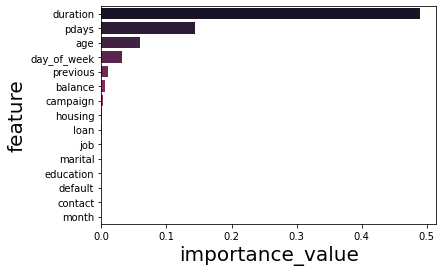

In [21]:
#Identify feature importances to understand which factors are most influential
importances = model1.named_steps['classifier'].feature_importances_

#Select only feature importance of feature present in original dataset
importances = importances[:X_train.shape[1]]

#Create a dataframe of feature importances
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

#Sort the dataframe by feature importance
importances_df.sort_values(by='importance', ascending=False, inplace=True)
# Create a horizontal bar chart
sns.barplot # Create a horizontal bar chart
sns.barplot(x='importance', y = 'feature', data=importances_df, palette = 'rocket')
sns.color_palette("rocket", as_cmap=True)
# Add axis labels
plt.ylabel('feature')
plt.xlabel('importance_value')


# Show the plot
plt.show()


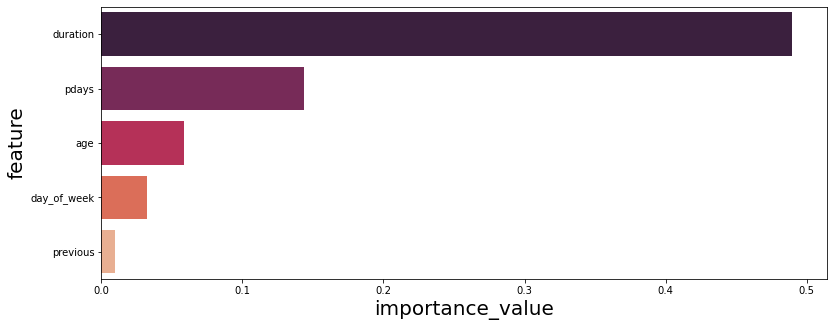

In [22]:
#Select top five important features
top_five = importances_df.nlargest(5,'importance')
#Create a horizontal bar chart
plt.figure(figsize=(13, 5))
sns.barplot # Create a horizontal bar chart
sns.barplot(x='importance', y = 'feature', data=top_five, palette = 'rocket')
sns.color_palette("rocket", as_cmap=True)
#Add axis labels
plt.ylabel('feature')
plt.xlabel('importance_value')
plt.show()
#Duration: last contact duration
#pday: number of days that passed by after the client was last contact
#age
#day_of_the_weeek day of last contact
#Previous: number of contacts performed before this campaign and for this client 